Celem projektu jest zbudowanie modelu, w ktorym zmienną prognozowaną jest liczba nadań w danym tygodniu.

Opis danych:

a) DimDates - Plik CSV - Baza danych z informacjami o datach (Rok, Miesiąc, Dzień, Dzień tygodnia, Weekend, Święto itp.) 

b) PostingVolumes - Plik Parquet - Baza danych z dziennymi nadaniami (Od 1 stycznia 2020 do 31 Grudnia 2024). 

Dane są zgrupowane per dzień w podziale na dwie usługi APM i COURIER zawierają 100 przykładowych klientów w tym odseparowanego klienta X oraz pozostałych 99 (A1, …, A99). Klienci Ci nie muszą mieć wszystkich produktów oraz mogą mieć historię dopiero od pewnego momentu. Klient X co miesiąc (pod koniec okresu) dostarcza nam swoją prognozę dziennych zamówień, które będą obsługiwane w ramach produktu APM na kolejny miesiąc. Klienci mają w ramach naszej firmy do dwóch usług a ich paczki są głownie nadawane i odbierane w Polsce (PL) natomiast zdarzają się również połączenia do Francji (FR)

c) X_ClientsORDERS - Plik EXCEL - Dane dostarczane przez klienta (X) od początku 2023 roku. Dane dotyczące nadchodzącego miesiąca są wysyłane pod koniec poprzedniego. Plik zawiera ilość zamówień (na platformie klienta) oczekiwanych przez zespół analityków klienta każdego dnia na najbliższy miesiąc na produkcie APM.

d) Zadanie_Dane_Temperatura - Folder z Plikami CSV - Folder zawiera pliki CSV, gdzie w każdym pliku (dla każdego miesiąca - między styczniem 2022 a grudniem 2024 roku) przechowywane są dane dotyczące temperatur (maksymalna, średnia, minimalna temperatura) oraz opadów (deszczu i śniegu). Dane są zebrane dla dwóch miast: WARSZAWA i KRAKÓW

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import os
import glob
import polars as pl
from datetime import datetime
import plotly.express as px
import nbformat
import scipy.stats as st

#from ydata_profiling import ProfileReport
import itertools
import plotly.io as pio
from IPython.core.display import HTML

# development
# pio.renderers.default = 'vscode'

# web export
pio.renderers.default = 'jpg'

# Wczytywanie, czyszczenie i łączenie danych

In [2]:
dimDates = pd.read_csv("dimDates.csv")
dimDates.head()

,Unnamed: 0,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,...,firstDayNoHolidayNoSaturdayAfter,firstDayNoHolidayNoSundayAfter,firstDayNoHolidayNoSaturdayAfterData,firstDayNoSaturdayNoHolidayOrSundayHolidayName,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,firstDayNoSaturdayNoHolidayOrSundayHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd
0,0,20230324,2023-03-24,2023,2023,2023-03-01,T12-2023,Q1-2023,3,24,...,20230326,20230325,20230326,SUN,0,20230326,0,0,0,0.0
1,1,20210701,2021-07-01,2021,2021,2021-07-01,T26-2021,Q3-2021,7,1,...,20210702,20210702,20210702,FRI,0,20210702,0,0,0,0.0
2,2,20210713,2021-07-13,2021,2021,2021-07-01,T28-2021,Q3-2021,7,13,...,20210714,20210714,20210714,WED,0,20210714,0,0,0,0.0
3,3,20240413,2024-04-13,2024,2024,2024-04-01,T15-2024,Q2-2024,4,13,...,20240414,20240415,20240414,SUN,0,20240414,0,0,0,0.0
4,4,20240715,2024-07-15,2024,2024,2024-07-01,T29-2024,Q3-2024,7,15,...,20240716,20240716,20240716,TUE,0,20240716,0,0,0,0.0


In [3]:
dimDates = dimDates.drop(columns="Unnamed: 0")
dimDates_polars = pl.from_pandas(dimDates).with_columns(
    pl.col("dateId").str.to_datetime("%Y-%m-%d", time_unit="ns")
)

In [4]:
dimDates_polars.describe()

statistic,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,dateWeekDay,dateWeekDayName,dateWeekDayNameShort,dateWeekDayNameFirstLetter,dateDayOfYear,dateWeekOfMonth,dateWeekOfYear,dateWeekOfYearISO,dateMonthName,dateMonthNameShort,dateMonthNameFirstLetter,dateQuarter,dateQuarterName,dateQuarterShort,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,dateWeekDayNamePL,dateMonthNamePL,dateWeekOfYearStartsMonday,firstDayWorkBefore,firstDayWorkAfter,firstDayNoHolidayNoSaturdayAfter,firstDayNoHolidayNoSundayAfter,firstDayNoHolidayNoSaturdayAfterData,firstDayNoSaturdayNoHolidayOrSundayHolidayName,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,firstDayNoSaturdayNoHolidayOrSundayHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd
str,f64,str,f64,f64,str,str,str,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,f64,str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64
"""count""",1827.0,"""1827""",1827.0,1827.0,"""1827""","""1827""","""1827""",1827.0,1827.0,"""1827""",1827.0,"""1827""","""1827""","""1827""",1827.0,1827.0,1827.0,1827.0,"""1827""","""1827""","""1827""",1827.0,"""1827""","""1827""",1827.0,1827.0,1827.0,"""1827""","""1827""",1827.0,1827.0,1827.0,1827.0,1827.0,1827.0,"""1827""",1827.0,1827.0,1827.0,1827.0,1827.0,1461.0
"""null_count""",0.0,"""0""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,"""0""",0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,366.0
"""mean""",2.0221e7,"""2022-07-02 00:00:00""",2022.0,2021.997811,null,null,null,6.521073,15.735085,null,4.0,null,null,null,183.200328,3.10509,27.028462,26.601533,null,null,null,2.507937,null,null,0.285714,0.036672,4.0,null,null,27.085386,2.0221e7,2.0221e7,2.0221e7,2.0221e7,2.0221e7,null,0.019704,2.0221e7,0.024083,0.019704,0.015326,0.015058
"""std""",14157.957457,null,1.415375,1.419237,null,null,null,3.450157,8.804801,null,2.000548,null,null,null,105.510948,1.319212,15.078119,15.072877,null,null,null,1.117577,null,null,0.451878,0.188007,2.000548,null,null,15.077904,14186.883407,14171.568556,14161.315708,14164.744672,14166.914548,null,0.139021,14166.922705,0.153349,0.139021,0.122878,0.121826
"""min""",2.0200101e7,"""2020-01-01 00:00:00""",2020.0,2020.0,"""2020-01-01""","""T1-2020""","""Q1-2020""",1.0,1.0,"""nd""",1.0,"""Friday""","""FRI""","""F""",1.0,1.0,1.0,1.0,"""April""","""APR""","""A""",1.0,"""First""","""Qtr 1""",0.0,0.0,1.0,"""Czwartek""","""Czerwiec""",1.0,2.0191231e7,2.0200102e7,2.0200102e7,2.0200102e7,2.0200102e7,"""FRI""",0.0,2.0200102e7,0.0,0.0,0.0,0.0
"""25%""",2.0210402e7,"""2021-04-02 00:00:00""",2021.0,2021.0,null,null,null,4.0,8.0,null,2.0,null,null,null,92.0,2.0,14.0,14.0,null,null,null,2.0,null,null,0.0,0.0,2.0,null,null,14.0,2.0210401e7,2.0210406e7,2.0210406e7,2.0210403e7,2.0210402e7,null,0.0,2.0210402e7,0.0,0.0,0.0,0.0
"""50%""",2.0220702e7,"""2022-07-02 00:00:00""",2022.0,2022.0,null,null,null,7.0,16.0,null,4.0,null,null,null,183.0,3.0,27.0,27.0,null,null,null,3.0,null,null,0.0,0.0,4.0,null,null,27.0,2.0220701e7,2.0220704e7,2.0220703e7,2.0220704e7,2.0220703e7,null,0.0,2.0220703e7,0.0,0.0,0.0,0.0
"""75%""",2.0231002e7,"""2023-10-02 00:00:00""",2023.0,2023.0,null,null,null,10.0,23.0,null,6.0,null,null,null,275.0,4.0,40.0,40.0,null,null,null,4.0,null,null,1.0,0.0,6.0,null,null,40.0,2.0230929e7,2.0231003e7,2.0231003e7,2.0231003e7,2.0231003e7,null,0.0,2.0231003e7,0.0,0.0,0.0,0.0
"""max""",2.0241231e7,"""2024-12-31 00:00:00""",2024.0,2025.0,"""2024-12-01""","""T9-2024""","""Q4-2024""",12.0,31.0,"""th""",7.0,"""Wednesday""","""WED""","""W""",366.0,6.0,53.0,53.0,"""September""","""SEP""","""S""",4.0,"""Third""","""Qtr 4""",1.0,1.0,7.0,"""Środa""","""Wrzesień""",53.0,2.024123e7,2.0250102e7,2.0250102e7,2.0250102e7,2.0250102e7,"""WED""",1.0,2.0250102e7,1.0,1.0,1.0,1.0


In [5]:
X_ClientOrders = pd.read_excel("X_ClientORDERS.xlsx")
X_ClientOrders.head()

,Date,APM_Orders
0,2023-01-01,117239.498822
1,2023-01-02,64143.840050
2,2023-01-03,61870.034653
3,2023-01-04,61013.341158
4,2023-01-05,55060.134348


In [6]:
X_ClientOrders_polars = (
    pl.DataFrame(X_ClientOrders)
    .rename({"APM_Orders": "Predictions_X"})
    .with_columns(
        [
            pl.lit("Customer_X").alias("Customer"),
            pl.lit("APM").alias("Product"),
        ]
    )
)

In [7]:
Posting_Volumes = pl.read_parquet("Posting_Volumes")
Posting_Volumes.head()

Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry
str,datetime[ns],str,i32,str,str
"""Customer_X""",2020-01-01 00:00:00,"""APM""",2281,"""PL""","""PL"""
"""Customer_X""",2020-01-01 00:00:00,"""COURIER""",2182,"""PL""","""PL"""
"""Customer_A1""",2020-01-01 00:00:00,"""COURIER""",59,"""PL""","""PL"""
"""Customer_A2""",2020-01-01 00:00:00,"""COURIER""",145,"""PL""","""PL"""
"""Customer_A3""",2020-01-01 00:00:00,"""APM""",65,"""PL""","""PL"""


In [8]:
Posting_Volumes.describe()

statistic,Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry
str,str,str,str,f64,str,str
"""count""","""257596""","""257596""","""257596""",257596.0,"""257596""","""257596"""
"""null_count""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,"""2022-08-10 10:42:15.803350""",null,5240.354544,null,null
"""std""",null,null,null,10314.54378,null,null
"""min""","""Customer_A1""","""2020-01-01 00:00:00""","""APM""",8.0,"""FR""","""FR"""
"""25%""",null,"""2021-05-15 00:00:00""",null,1578.0,null,null
"""50%""",null,"""2022-08-31 00:00:00""",null,3228.0,null,null
"""75%""",null,"""2023-11-16 00:00:00""",null,5659.0,null,null
"""max""","""Customer_X""","""2024-12-31 00:00:00""","""COURIER""",223604.0,"""PL""","""PL"""


In [9]:
Posting_Volumes.filter(pl.col("Customer") == "Customer_X").describe()

statistic,Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry
str,str,str,str,f64,str,str
"""count""","""3654""","""3654""","""3654""",3654.0,"""3654""","""3654"""
"""null_count""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,"""2022-07-02 00:00:00""",null,76080.701697,null,null
"""std""",null,null,null,36505.321404,null,null
"""min""","""Customer_X""","""2020-01-01 00:00:00""","""APM""",823.0,"""PL""","""PL"""
"""25%""",null,"""2021-04-01 00:00:00""",null,51826.0,null,null
"""50%""",null,"""2022-07-02 00:00:00""",null,75704.0,null,null
"""75%""",null,"""2023-10-02 00:00:00""",null,99529.0,null,null
"""max""","""Customer_X""","""2024-12-31 00:00:00""","""COURIER""",223604.0,"""PL""","""PL"""


In [10]:
Posting_Volumes.filter(pl.col("Customer") != "Customer_X").describe()

statistic,Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry
str,str,str,str,f64,str,str
"""count""","""253942""","""253942""","""253942""",253942.0,"""253942""","""253942"""
"""null_count""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,"""2022-08-11 00:19:35.852753""",null,4221.024821,null,null
"""std""",null,null,null,3937.17775,null,null
"""min""","""Customer_A1""","""2020-01-01 00:00:00""","""APM""",8.0,"""FR""","""FR"""
"""25%""",null,"""2021-05-16 00:00:00""",null,1560.0,null,null
"""50%""",null,"""2022-09-01 00:00:00""",null,3175.0,null,null
"""75%""",null,"""2023-11-16 00:00:00""",null,5523.0,null,null
"""max""","""Customer_A99""","""2024-12-31 00:00:00""","""COURIER""",61733.0,"""PL""","""PL"""


In [11]:
file_list = glob.glob("Zadanie_Dane_Temperatura/*")

df_dane_temperatura = pd.concat([pd.read_csv(f) for f in file_list], ignore_index=True)
df_dane_temperatura.head()

,Nazwa stacji,Rok,Miesiac,Dzien,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,KRAKOW,2023,5,1,19.2,2.1,11.1,0.0,0.0
1,KRAKOW,2023,5,2,22.3,6.1,13.0,22.4,0.0
2,KRAKOW,2023,5,3,12.9,10.1,11.1,2.9,0.0
3,KRAKOW,2023,5,4,16.5,5.0,10.6,0.0,0.0
4,KRAKOW,2023,5,5,19.5,5.9,12.7,0.0,0.0


In [12]:
df_dane_temperatura["Data"] = pd.to_datetime(
    df_dane_temperatura.rename(
        columns={"Rok": "year", "Miesiac": "month", "Dzien": "day"}
    )[["year", "month", "day"]]
)

In [13]:
df_dane_temperatura_polars = (
    pl.DataFrame(df_dane_temperatura)
    .rename(
        {
            "Maksymalna temperatura dobowa": "tempMax",
            "Minimalna temperatura dobowa": "tempMin",
            "Srednia temperatura dobowa": "tempAvg",
            "Suma dobowa opadow [mm]": "rainMm",
            "Pokrywa sniegu [cm]": "snowCm",
        }
    )
    .with_columns(
        pl.when(pl.col("Nazwa stacji") == "WARSZAWA")
        .then(pl.lit("Warsaw"))
        .otherwise(pl.lit("Krakow"))
        .alias("station")
    )
)

In [14]:
df_dane_temperatura_szeroka = df_dane_temperatura_polars.pivot(
    index="Data",
    on="station",
    values=["tempMax", "tempMin", "tempAvg", "rainMm", "snowCm"],
    separator="",
)
df_dane_temperatura_szeroka.describe()

statistic,Data,tempMaxKrakow,tempMaxWarsaw,tempMinKrakow,tempMinWarsaw,tempAvgKrakow,tempAvgWarsaw,rainMmKrakow,rainMmWarsaw,snowCmKrakow,snowCmWarsaw
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1096""",1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,967.0,851.0,855.0,851.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,129.0,245.0,241.0,245.0
"""mean""","""2023-07-02 12:00:00""",16.293339,14.669252,6.923723,7.000182,11.025912,10.389781,2.301241,0.0,0.818713,0.0
"""std""",null,9.501482,9.479238,6.960575,7.021741,7.97428,7.979997,5.121816,0.0,3.259089,0.0
"""min""","""2022-01-01 00:00:00""",-10.5,-9.8,-16.7,-14.2,-14.2,-12.1,0.0,0.0,0.0,0.0
"""25%""","""2022-10-02 00:00:00""",8.4,6.7,1.1,1.2,4.3,3.6,0.0,0.0,0.0,0.0
"""50%""","""2023-07-03 00:00:00""",16.9,14.4,6.9,6.7,10.8,10.1,0.1,0.0,0.0,0.0
"""75%""","""2024-04-01 00:00:00""",24.4,23.1,12.6,12.9,18.1,17.6,2.2,0.0,0.0,0.0
"""max""","""2024-12-31 00:00:00""",36.7,34.3,21.1,21.9,28.2,26.9,75.0,0.0,27.0,0.0


Dane o temperaturze są dostępne od 2022-01-01 do 2024-01-01.

Dane rainMmWarsaw i snowCmWarsaw zawierają po 245 nulli, a wartości, które są dostępne wynoszą 0 dla każdej dostęnej daty.

In [15]:
selected_cols = ["rainMmKrakow", "rainMmWarsaw", "snowCmKrakow", "snowCmWarsaw"]
df_temp = df_dane_temperatura_szeroka.with_columns(
    pl.col("Data").dt.month().alias("month")
)
print(
    [
        df_temp.filter(pl.col(c).is_null())
        .group_by("month")
        .agg([pl.len().alias(f"{c}_missing")])
        .sort(pl.col("month"))
        for c in selected_cols
    ]
)

[shape: (8, 2)
┌───────┬──────────────────────┐
│ month ┆ rainMmKrakow_missing │
│ ---   ┆ ---                  │
│ i8    ┆ u32                  │
╞═══════╪══════════════════════╡
│ 5     ┆ 20                   │
│ 6     ┆ 12                   │
│ 7     ┆ 18                   │
│ 8     ┆ 21                   │
│ 9     ┆ 20                   │
│ 10    ┆ 19                   │
│ 11    ┆ 8                    │
│ 12    ┆ 11                   │
└───────┴──────────────────────┘, shape: (8, 2)
┌───────┬──────────────────────┐
│ month ┆ rainMmWarsaw_missing │
│ ---   ┆ ---                  │
│ i8    ┆ u32                  │
╞═══════╪══════════════════════╡
│ 5     ┆ 31                   │
│ 6     ┆ 30                   │
│ 7     ┆ 31                   │
│ 8     ┆ 31                   │
│ 9     ┆ 30                   │
│ 10    ┆ 31                   │
│ 11    ┆ 30                   │
│ 12    ┆ 31                   │
└───────┴──────────────────────┘, shape: (8, 2)
┌───────┬──────────────────────

Warszawa - brak danych o śniegu i deszczu dla miesięcy maj-grudzień.

Krakow - braki danych również występują tylko dla miesięcy maj-grudzień, z czego pomiary dla opadów śniegu dostępne są tylko dla listopada i grudnia; może to wskazywać na to, że brak pomiarów w rzeczywistości oznacza brak śniegu w danym dniu i analogicznie
dla deszczu w Krakowie.
Z tego powodu brakujące dane o opadach śniegu i deszczu w Krakowie zdecydowałam się zastąpić wartością 0.

Nie zdecydowałam się również na uzupełnianie danych dla Warszawy - dane o opadach śniegu/deszczu w Warszawie nie zostaną uwzględnione w dalszej analizie.

In [16]:
df_dane_temperatura_wypelniona = df_dane_temperatura_szeroka.with_columns(
    [
        pl.col("rainMmKrakow").fill_null(value=0).alias("rainMmKrakow"),
        pl.col("snowCmKrakow").fill_null(value=0).alias("snowCmKrakow"),
    ]
).drop(["rainMmWarsaw", "snowCmWarsaw"])

df_dane_temperatura_wypelniona.describe()

statistic,Data,tempMaxKrakow,tempMaxWarsaw,tempMinKrakow,tempMinWarsaw,tempAvgKrakow,tempAvgWarsaw,rainMmKrakow,snowCmKrakow
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1096""",1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0,1096.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2023-07-02 12:00:00""",16.293339,14.669252,6.923723,7.000182,11.025912,10.389781,2.030383,0.638686
"""std""",null,9.501482,9.479238,6.960575,7.021741,7.97428,7.979997,4.867544,2.898105
"""min""","""2022-01-01 00:00:00""",-10.5,-9.8,-16.7,-14.2,-14.2,-12.1,0.0,0.0
"""25%""","""2022-10-02 00:00:00""",8.4,6.7,1.1,1.2,4.3,3.6,0.0,0.0
"""50%""","""2023-07-03 00:00:00""",16.9,14.4,6.9,6.7,10.8,10.1,0.0,0.0
"""75%""","""2024-04-01 00:00:00""",24.4,23.1,12.6,12.9,18.1,17.6,1.6,0.0
"""max""","""2024-12-31 00:00:00""",36.7,34.3,21.1,21.9,28.2,26.9,75.0,27.0


In [17]:
df1 = Posting_Volumes.join(
    dimDates_polars, left_on="Date", right_on="dateId", how="left"
)
df2 = df1.join(X_ClientOrders_polars, on=["Date", "Customer", "Product"], how="left")
df_joined = df2.join(
    df_dane_temperatura_wypelniona, left_on="Date", right_on="Data", how="left"
)

# Eksploracyjna analiza danych

In [18]:
df_joined.describe()

statistic,Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry,datePk,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,dateWeekDay,dateWeekDayName,dateWeekDayNameShort,dateWeekDayNameFirstLetter,dateDayOfYear,dateWeekOfMonth,dateWeekOfYear,dateWeekOfYearISO,dateMonthName,dateMonthNameShort,dateMonthNameFirstLetter,dateQuarter,dateQuarterName,dateQuarterShort,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,dateWeekDayNamePL,dateMonthNamePL,dateWeekOfYearStartsMonday,firstDayWorkBefore,firstDayWorkAfter,firstDayNoHolidayNoSaturdayAfter,firstDayNoHolidayNoSundayAfter,firstDayNoHolidayNoSaturdayAfterData,firstDayNoSaturdayNoHolidayOrSundayHolidayName,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,firstDayNoSaturdayNoHolidayOrSundayHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,Predictions_X,tempMaxKrakow,tempMaxWarsaw,tempMinKrakow,tempMinWarsaw,tempAvgKrakow,tempAvgWarsaw,rainMmKrakow,snowCmKrakow
str,str,str,str,f64,str,str,f64,f64,f64,str,str,str,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,f64,str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""257596""","""257596""","""257596""",257596.0,"""257596""","""257596""",257596.0,257596.0,257596.0,"""257596""","""257596""","""257596""",257596.0,257596.0,"""257596""",257596.0,"""257596""","""257596""","""257596""",257596.0,257596.0,257596.0,257596.0,"""257596""","""257596""","""257596""",257596.0,"""257596""","""257596""",257596.0,257596.0,257596.0,"""257596""","""257596""",257596.0,257596.0,257596.0,257596.0,257596.0,257596.0,"""257596""",257596.0,257596.0,257596.0,257596.0,257596.0,211107.0,731.0,161976.0,161976.0,161976.0,161976.0,161976.0,161976.0,161976.0,161976.0
"""null_count""","""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,"""0""",0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,46489.0,256865.0,95620.0,95620.0,95620.0,95620.0,95620.0,95620.0,95620.0,95620.0
"""mean""",null,"""2022-08-10 10:42:15.803350""",null,5240.354544,null,null,2.0222e7,2022.104571,2022.102672,null,null,null,6.561934,15.74651,null,3.999732,null,null,null,184.458175,3.105898,27.192895,26.763925,null,null,null,2.520645,null,null,0.285726,0.036596,3.999775,null,null,27.260152,2.0222e7,2.0222e7,2.0222e7,2.0222e7,2.0222e7,null,0.019267,2.0222e7,0.024162,0.019566,0.014985,0.014301,84139.982632,16.340057,14.716606,6.967387,7.045453,11.070263,10.43593,2.039338,0.632433
"""std""",null,null,null,10314.54378,null,null,14160.924347,1.415649,1.419768,null,null,null,3.448959,8.802856,null,2.000059,null,null,null,105.481078,1.318668,15.073816,15.066932,null,null,null,1.117168,null,null,0.451761,0.187768,2.000182,null,null,15.073708,14190.003028,14174.143057,14163.883322,14167.636017,14169.671252,null,0.137461,14169.668966,0.153552,0.138502,0.121492,0.118728,25579.423135,9.498182,9.482932,6.953122,7.011991,7.970368,7.977432,4.908529,2.877965
"""min""","""Customer_A1""","""2020-01-01 00:00:00""","""APM""",8.0,"""FR""","""FR""",2.0200101e7,2020.0,2020.0,"""2020-01-01""","""T1-2020""","""Q1-2020""",1.0,1.0,"""nd""",1.0,"""Friday""","""FRI""","""F""",1.0,1.0,1.0,1.0,"""April""","""APR""","""A""",1.0,"""First""","""Qtr 1""",0.0,0.0,1.0,"""Czwartek""","""Czerwiec""",1.0,2.0191231e7,2.0200102e7,2.0200102e7,2.0200102e7,2.0200102e7,"""FRI""",0.0,2.0200102e7,0.0,0.0,0.0,0.0,11640.205062,-10.5,-9.8,-16.7,-14.2,-14.2,-12.1,0.0,0.0
"""25%""",null,"""2021-05-15 00:00:00""",null,1578.0,null,null,2.0210515e7,2021.0,2021.0,null,null,null,4.0,8.0,null,2.0,null,null,null,93.0,2.0,14.0,14.0,null,null,null,2.0,null,null,0.0,0.0,2.0,null,null,14.0,2.0210514e7,2.0210517e7,2.0210516e7,2.0210517e7,2.0210516e7,null,0.0,2.0210516e7,0.0,0.0,0.0,0.0,65993.885233,8.4,6.7,1.2,1.3,4.4,3.7,0.0,0.0
"""50%""

In [19]:
df_joined.filter(
    df_joined.select(
        ["Customer", "Date", "Product", "CollectionCountry", "DeliveryCountry"]
    ).is_duplicated()
)



Customer,Date,Product,Volume,CollectionCountry,DeliveryCountry,datePk,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,dateWeekDay,dateWeekDayName,dateWeekDayNameShort,dateWeekDayNameFirstLetter,dateDayOfYear,dateWeekOfMonth,dateWeekOfYear,dateWeekOfYearISO,dateMonthName,dateMonthNameShort,dateMonthNameFirstLetter,dateQuarter,dateQuarterName,dateQuarterShort,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,dateWeekDayNamePL,dateMonthNamePL,dateWeekOfYearStartsMonday,firstDayWorkBefore,firstDayWorkAfter,firstDayNoHolidayNoSaturdayAfter,firstDayNoHolidayNoSundayAfter,firstDayNoHolidayNoSaturdayAfterData,firstDayNoSaturdayNoHolidayOrSundayHolidayName,firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday,firstDayNoSaturdayNoHolidayOrSundayHoliday,isThuHolyday,isFriHolyday,isSatHolyday,isWeekendParcelServiceBreakInd,Predictions_X,tempMaxKrakow,tempMaxWarsaw,tempMinKrakow,tempMinWarsaw,tempAvgKrakow,tempAvgWarsaw,rainMmKrakow,snowCmKrakow
str,datetime[ns],str,i32,str,str,i64,i64,i64,str,str,str,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,str,str,str,i64,str,str,i64,i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64


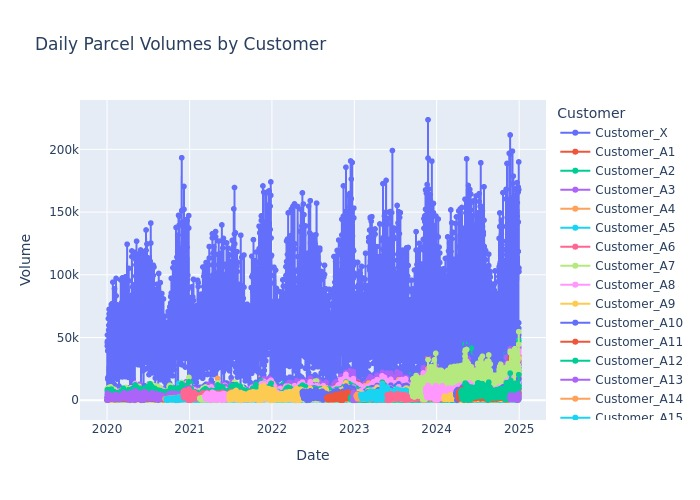

In [20]:
fig = px.line(
    df_joined,
    x="Date",
    y="Volume",
    color="Customer",
    title="Daily Parcel Volumes by Customer",
    markers=True,
)

# fig.show()
pio.show(fig)

In [21]:
df_joined_final = df_joined.with_columns(
    pl.col("Date").dt.truncate("1w").alias("week_start")
)
df_weekly_customer = df_joined_final.with_columns(
        pl.col("Volume")
        .sum()
        .over(["week_start", "Customer"])
        .alias("weekly_volume")
    )

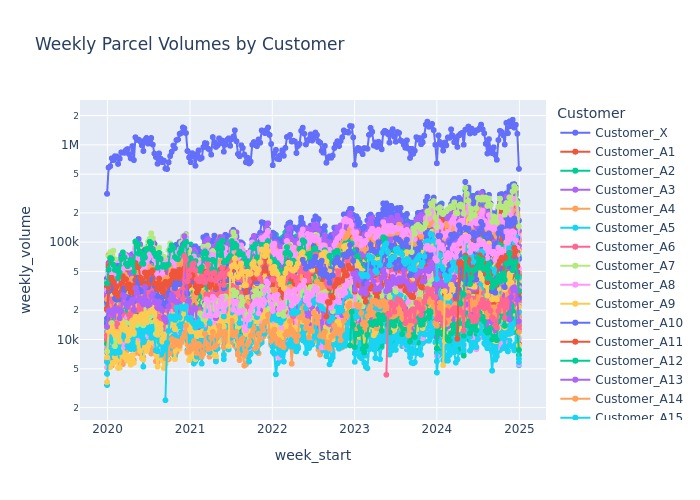

In [22]:
fig = px.line(
    df_weekly_customer,
    x="week_start",
    y="weekly_volume",
    color="Customer",
    title="Weekly Parcel Volumes by Customer",
    markers=True,
)

fig.update_layout(yaxis_type="log")

pio.show(fig)

In [23]:
df_sums = (
    df_joined.group_by("Customer")
    .agg(
        pl.sum("Volume").alias("total_volume"),
        pl.mean("Volume").alias("avg_daily_volume"),
        pl.min("Volume").alias("min_daily_volume"),
        pl.max("Volume").alias("max_daily_volume"),
        pl.median("Volume").alias("median_daily_volume"),
    )
    .sort("avg_daily_volume", descending=True)
)

df_sums

Customer,total_volume,avg_daily_volume,min_daily_volume,max_daily_volume,median_daily_volume
str,i32,f64,i32,i32,f64
"""Customer_X""",277998884,76080.701697,823,223604,75696.0
"""Customer_A85""",15245474,16014.153361,272,54681,15935.5
"""Customer_A44""",39765133,10882.630816,64,61733,9194.0
"""Customer_A21""",35153257,9620.486316,52,57392,7803.5
"""Customer_A12""",34634632,9478.552819,65,47184,7897.0
…,…,…,…,…,…
"""Customer_A90""",1532585,1025.82664,11,3442,1019.5
"""Customer_A11""",3485641,953.92474,12,3096,958.0
"""Customer_A15""",3328333,910.873837,10,2938,895.0


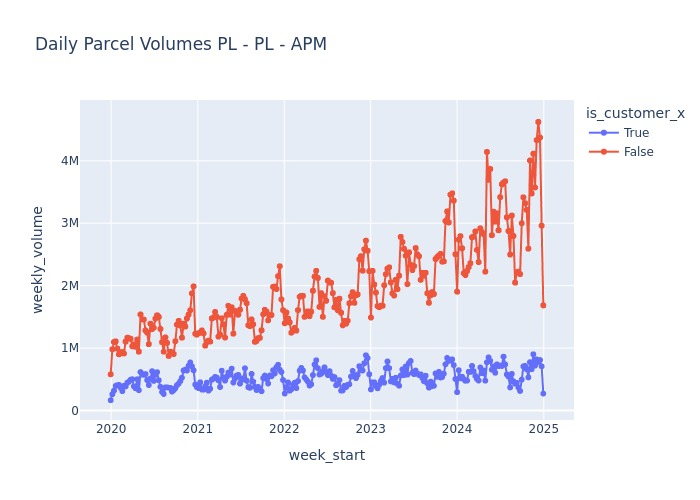

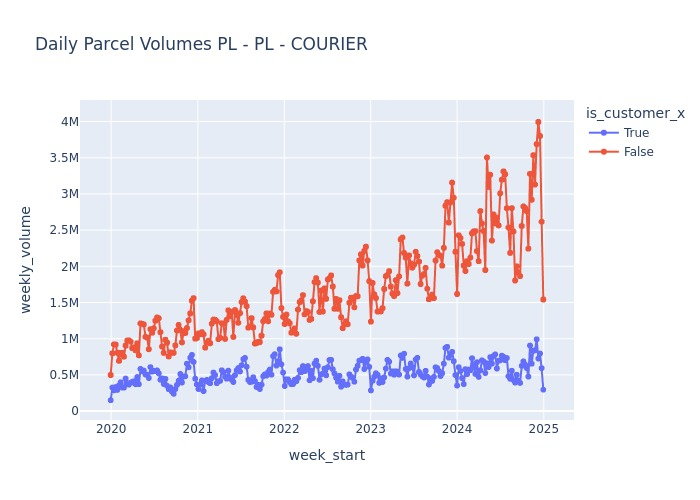

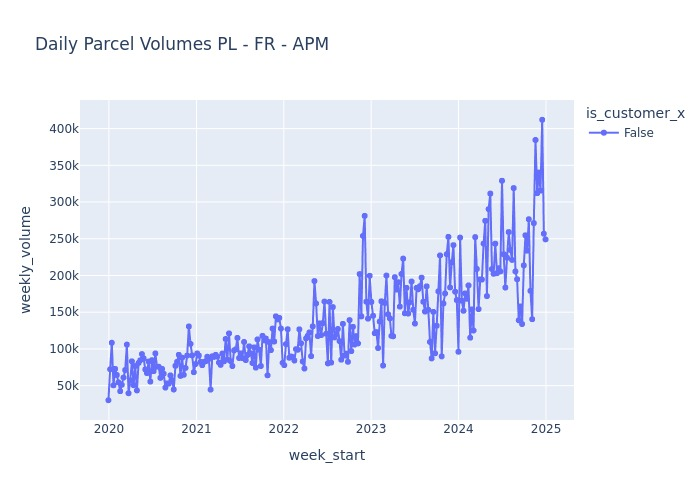

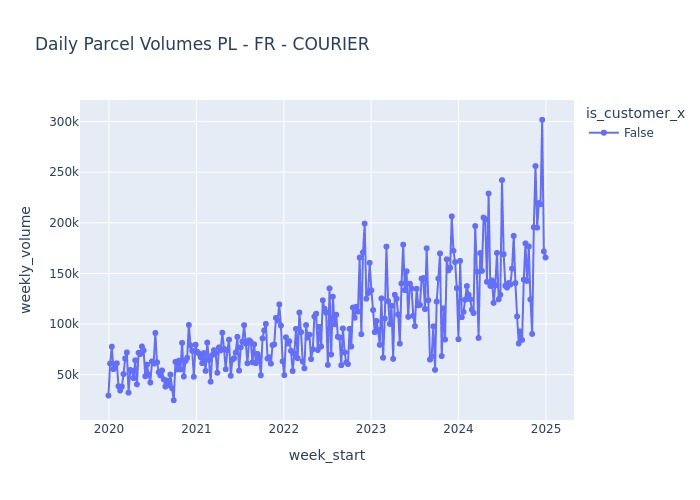

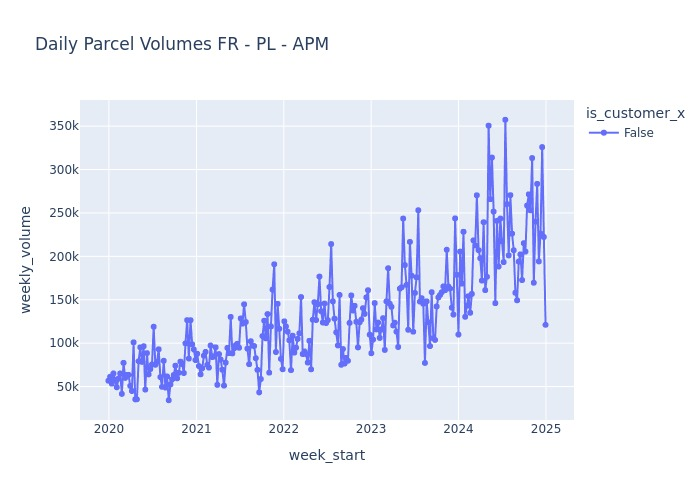

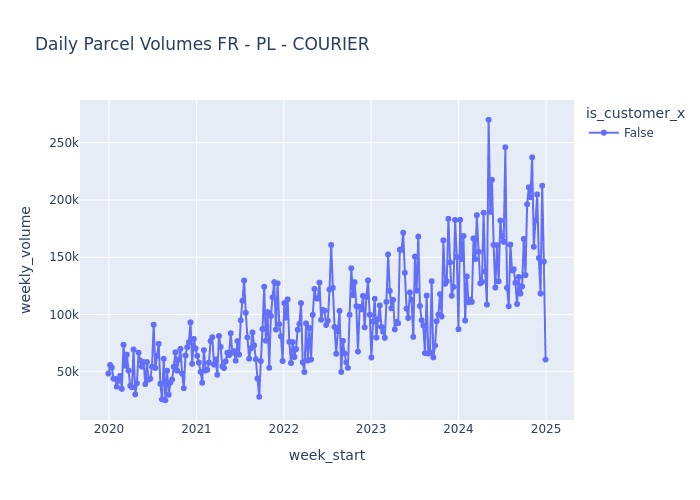

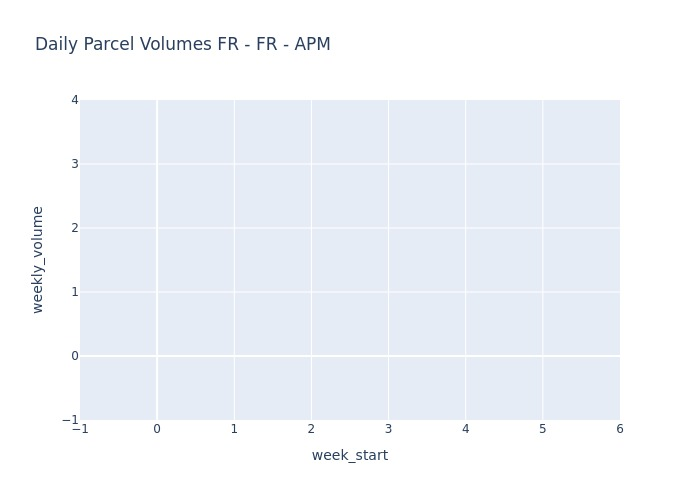

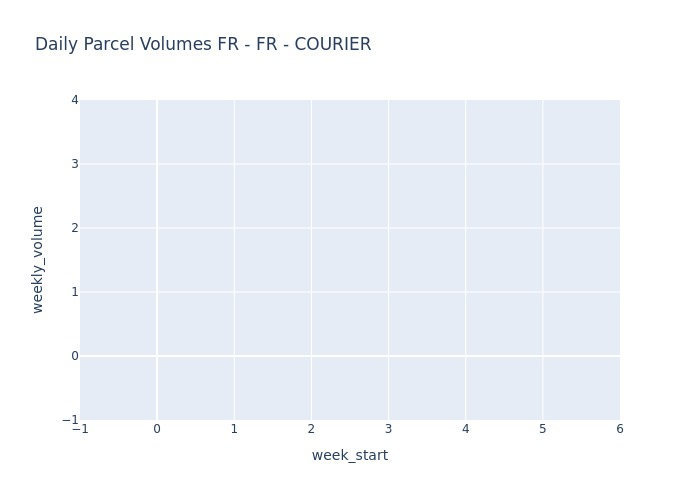

In [24]:
list_variables = [["PL", "FR"], ["PL", "FR"], ["APM", "COURIER"]]

for collection, delivery, product in itertools.product(*list_variables):
    df_filtered = df_joined_final.filter(
        (pl.col("CollectionCountry") == pl.lit(collection))
        & (pl.col("DeliveryCountry") == pl.lit(delivery))
        & (pl.col("Product") == pl.lit(product))
    )

    df_weekly_delivery = df_filtered.with_columns(
        (pl.col("Customer") == pl.lit("Customer_X")).alias("is_customer_x")
    ).with_columns(
        pl.col("Volume")
        .sum()
        .over(["week_start", "is_customer_x"])
        .alias("weekly_volume")
    )

    fig = px.line(
        df_weekly_delivery,
        x="week_start",
        y="weekly_volume",
        color="is_customer_x",
        title=f"Daily Parcel Volumes {collection} - {delivery} - {product}",
        labels={"date": "Date", "volume": "Total Parcels"},
        markers=True,
    )

    # fig.show()
    pio.show(fig)

Zdecydowałam się na budowę modelu dla klienta Customer_X osobno ze względu na dostarczaną prognozę i wyraźnie wyższe średnie ilości wysyłanych paczek. Co więcej, klient X operuje tylko w obrębie Polski, więc nie będę w jego przypadku brać pod uwagę zmiennych deliveryCountry i collectionCountry. 

In [25]:
df_joined_final = df_joined_final.with_columns((pl.col("Customer") == pl.lit("Customer_X")).cast(pl.Int32).alias("is_customer_x"))

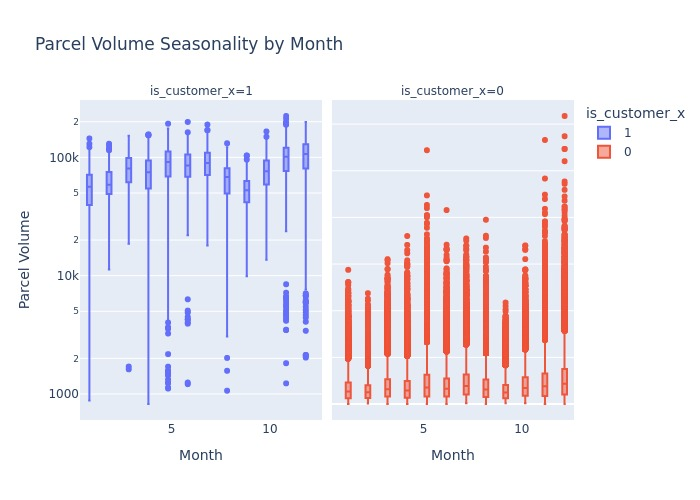

In [26]:
fig = px.box(
    df_joined_final,
    x="dateMonth",
    y="Volume",
    facet_col = "is_customer_x",
    color = "is_customer_x",
    title="Parcel Volume Seasonality by Month",
    labels={"dateMonth": "Month", "Volume": "Parcel Volume"},
    category_orders={"dateMonth": list(range(1, 13))},
)
fig.update_layout(yaxis_type="log")
# fig.show()
pio.show(fig)

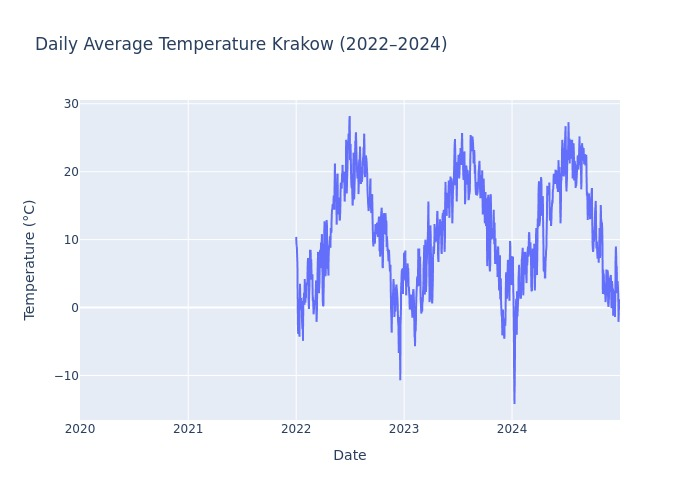

In [27]:
fig = px.line(
    df_joined,
    x="Date",
    y="tempAvgKrakow",  
    title="Daily Average Temperature Krakow (2022–2024)",
    labels={"Date": "Date", "tempAvgKrakow": "Temperature (°C)"},
)
# fig.show()
pio.show(fig)


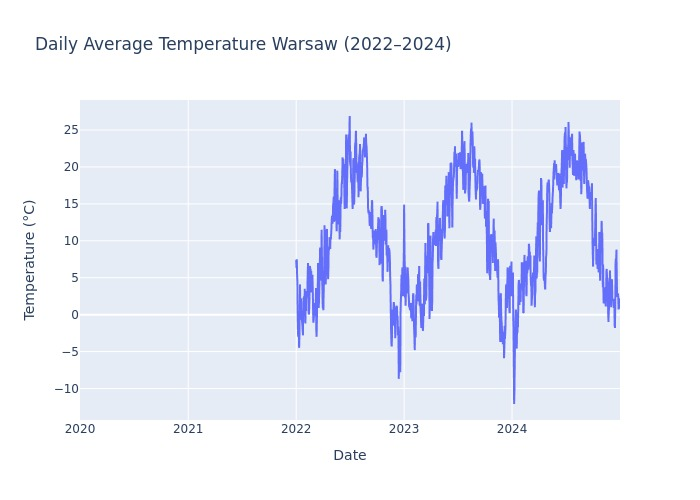

In [28]:

fig = px.line(
    df_joined,
    x="Date",
    y="tempAvgWarsaw",  
    title="Daily Average Temperature Warsaw (2022–2024)",
    labels={"Date": "Date", "tempAvgWarsaw": "Temperature (°C)"},
)
# fig.show()
pio.show(fig)


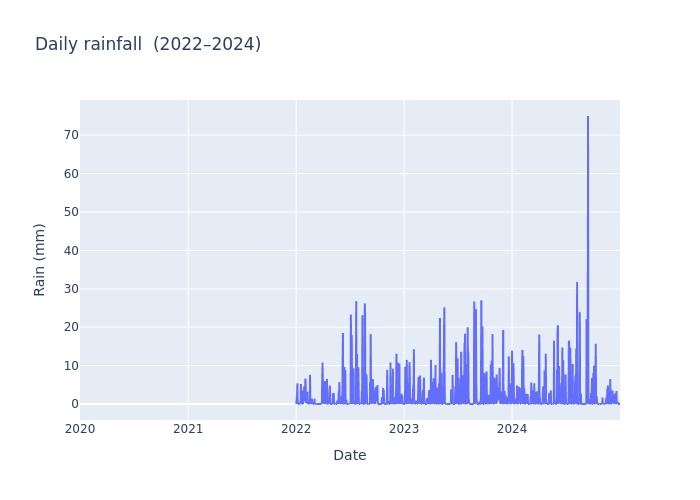

In [29]:

fig = px.line(
    df_joined,
    x="Date",
    y="rainMmKrakow",  
    title="Daily rainfall  (2022–2024)",
    labels={"Date": "Date", "rainMmKrakow": "Rain (mm)"},
)
# fig.show()
pio.show(fig)


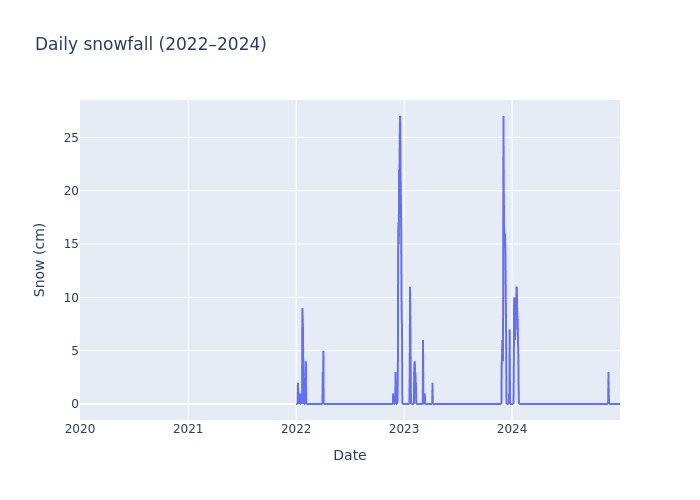

In [30]:

fig = px.line(
    df_joined,
    x="Date",
    y="snowCmKrakow",  
    title="Daily snowfall (2022–2024)",
    labels={"Date": "Date", "snowCmKrakow": "Snow (cm)"},
)
# fig.show()
pio.show(fig)

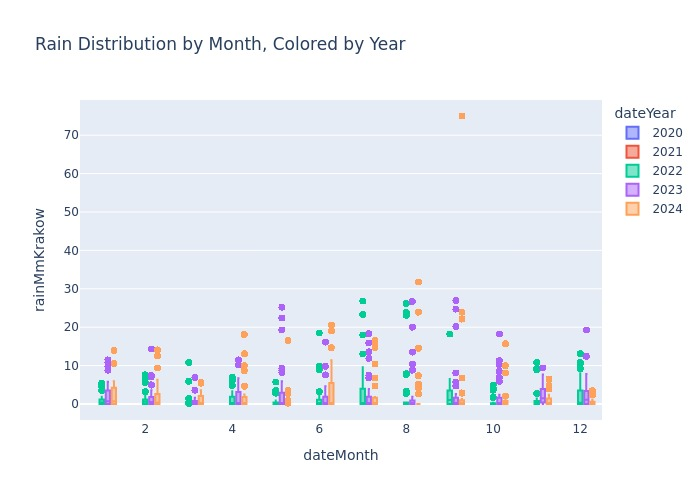

In [31]:
fig = px.box(
    df_joined_final,
    x="dateMonth",
    y="rainMmKrakow",
    color="dateYear",
    title="Rain Distribution by Month, Colored by Year",
)
# fig.show()
pio.show(fig)


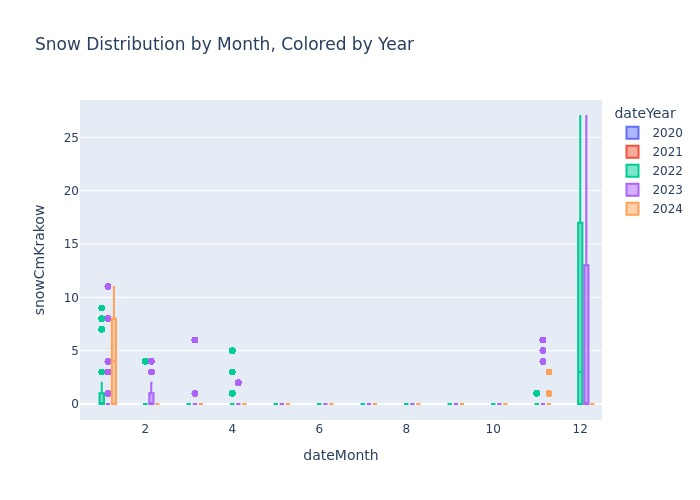

In [32]:

fig = px.box(
    df_joined_final,
    x="dateMonth",
    y="snowCmKrakow",
    color="dateYear",
    title="Snow Distribution by Month, Colored by Year",
)
# fig.show()
pio.show(fig)

In [33]:
df_corr = df_joined.select(
    [
        pl.corr("Volume", "tempMaxKrakow").alias("corr_temp_max"),
        pl.corr("Volume", "tempMinKrakow").alias("corr_rain_min"),
        pl.corr("Volume", "tempAvgKrakow").alias("corr_rain_avg"),
        pl.corr("Volume", "snowCmKrakow").alias("corr_snow"),
        pl.corr("Volume", "rainMmKrakow").alias("corr_rain"),
    ]
)
print(df_corr)

df_corr = df_joined.select(
    [
        pl.corr("Volume", "tempMaxWarsaw").alias("corr_temp_max"),
        pl.corr("Volume", "tempMinWarsaw").alias("corr_rain_min"),
        pl.corr("Volume", "tempAvgWarsaw").alias("corr_rain_avg"),
    ]
)
print(df_corr)

shape: (1, 5)
┌───────────────┬───────────────┬───────────────┬───────────┬───────────┐
│ corr_temp_max ┆ corr_rain_min ┆ corr_rain_avg ┆ corr_snow ┆ corr_rain │
│ ---           ┆ ---           ┆ ---           ┆ ---       ┆ ---       │
│ f64           ┆ f64           ┆ f64           ┆ f64       ┆ f64       │
╞═══════════════╪═══════════════╪═══════════════╪═══════════╪═══════════╡
│ -0.005364     ┆ -0.003588     ┆ -0.003687     ┆ 0.015846  ┆ 0.003178  │
└───────────────┴───────────────┴───────────────┴───────────┴───────────┘
shape: (1, 3)
┌───────────────┬───────────────┬───────────────┐
│ corr_temp_max ┆ corr_rain_min ┆ corr_rain_avg │
│ ---           ┆ ---           ┆ ---           │
│ f64           ┆ f64           ┆ f64           │
╞═══════════════╪═══════════════╪═══════════════╡
│ -0.007418     ┆ -0.004875     ┆ -0.005049     │
└───────────────┴───────────────┴───────────────┘


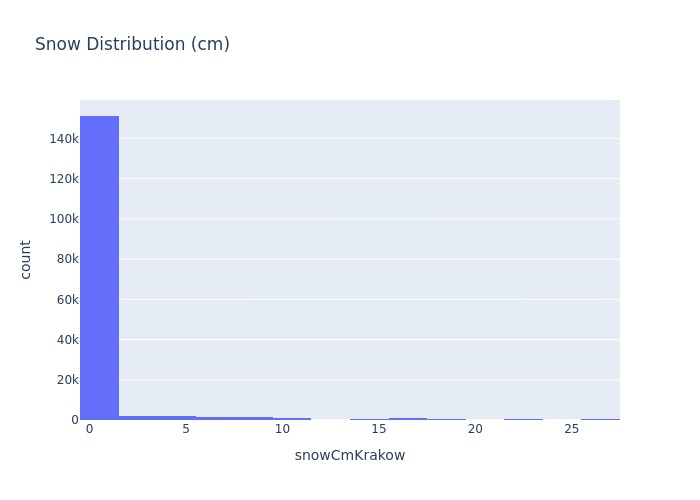

4.0


In [34]:
fig = px.histogram(
    df_joined, x="snowCmKrakow", nbins=25, title="Snow Distribution (cm)"
)
# fig.show()
pio.show(fig)
q95_snow = df_joined.select(pl.col("snowCmKrakow").quantile(0.95)).to_series()[0]
print(q95_snow)  # 5 cm


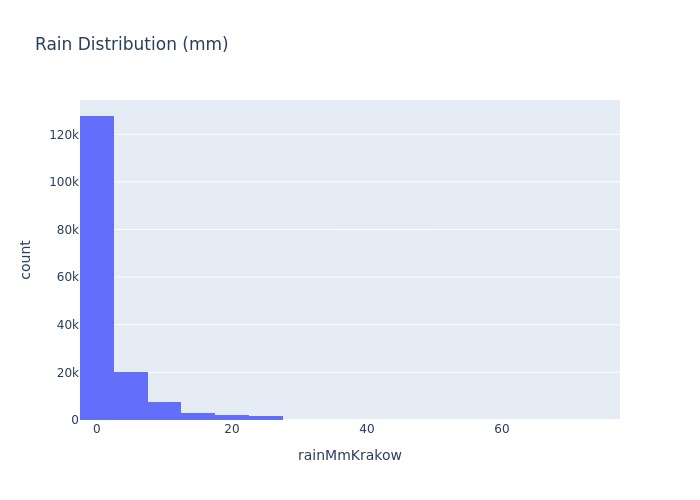

10.8


In [35]:

fig = px.histogram(
    df_joined, x="rainMmKrakow", nbins=25, title="Rain Distribution (mm)"
)
# fig.show()
pio.show(fig)

q95_rain = df_joined.select(pl.col("rainMmKrakow").quantile(0.95)).to_series()[0]
print(q95_rain)  # 14.1 mm

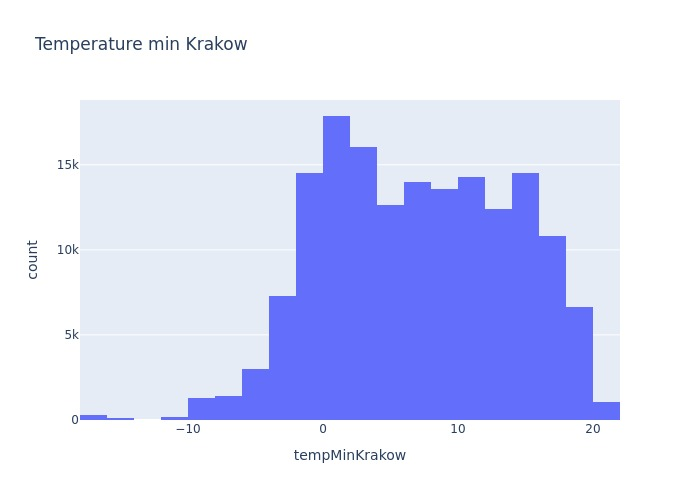

-3.5


In [36]:
fig = px.histogram(df_joined, x="tempMinKrakow", nbins=25, title="Temperature min Krakow")
# fig.show()
pio.show(fig)

q05_temp_krakow = df_joined.select(pl.col("tempMinKrakow").quantile(0.05)).to_series()[
    0
]
print(q05_temp_krakow)  # -3.5

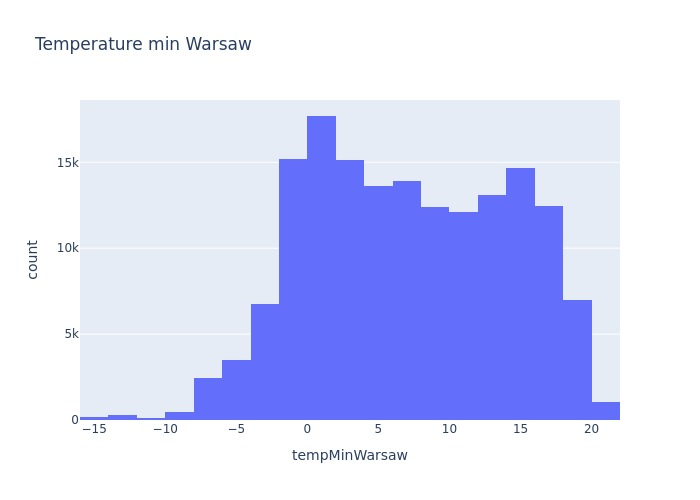

-3.8


In [37]:

fig = px.histogram(df_joined, x="tempMinWarsaw", nbins=25, title="Temperature min Warsaw")
# fig.show()
pio.show(fig)


q05_temp_warsaw = df_joined.select(pl.col("tempMinWarsaw").quantile(0.05)).to_series()[
    0
]
print(q05_temp_warsaw)  # -3.8

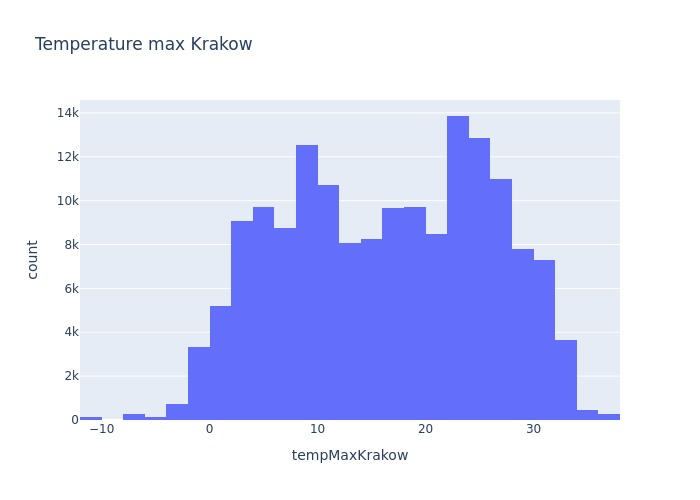

30.7


In [38]:
fig = px.histogram(df_joined, x="tempMaxKrakow", nbins=25, title="Temperature max Krakow")
# fig.show()
pio.show(fig)

q95_temp_krakow = df_joined.select(pl.col("tempMaxKrakow").quantile(0.95)).to_series()[
    0
]
print(q95_temp_krakow)  # 30.7


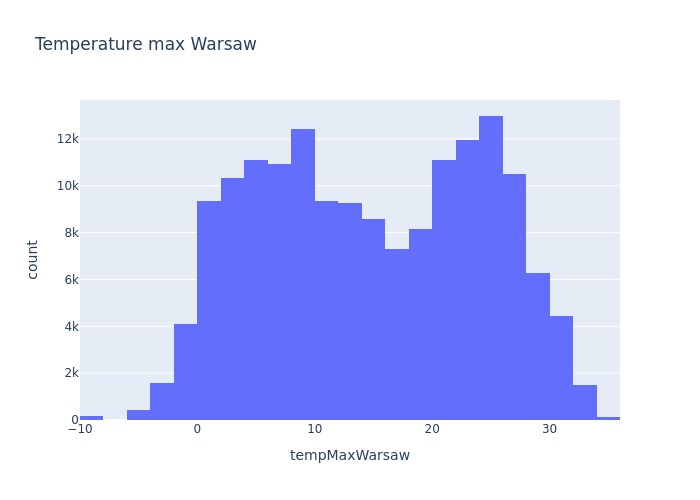

29.2


In [39]:

fig = px.histogram(df_joined, x="tempMaxWarsaw", nbins=25, title="Temperature max Warsaw")
# fig.show()
pio.show(fig)

q95_temp_warsaw = df_joined.select(pl.col("tempMaxWarsaw").quantile(0.95)).to_series()[
    0
]
print(q95_temp_warsaw)  # 29.2

Tworzę nowe zmienne określające ekstremalne warunki pogodowe

In [40]:
df_joined_final = df_joined_final.with_columns(
    [
        (pl.col("snowCmKrakow") > q95_snow).cast(pl.Int8).alias("extremeSnowDay"),
        (pl.col("rainMmKrakow") > q95_rain).cast(pl.Int8).alias("extremeRainDay"),
        (pl.col("tempMaxKrakow") > q95_temp_krakow)
        .cast(pl.Int8)
        .alias("extremeHighTempDayKrakow"),
        (pl.col("tempMaxWarsaw") > q95_temp_warsaw)
        .cast(pl.Int8)
        .alias("extremeHighTempDayWarsaw"),
        (pl.col("tempMinKrakow") < q05_temp_krakow)
        .cast(pl.Int8)
        .alias("extremeLowTempDayKrakow"),
        (pl.col("tempMinWarsaw") < q05_temp_warsaw)
        .cast(pl.Int8)
        .alias("extremeLowTempDayWarsaw"),
    ]
)


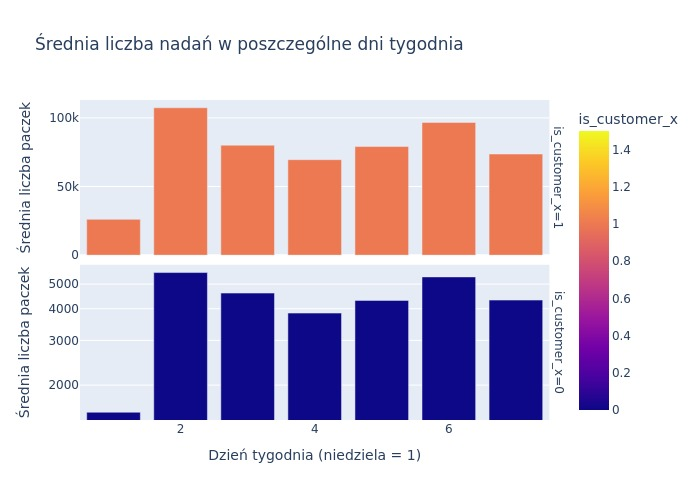

In [41]:
df_grouped_weekday = df_joined_final.group_by(["dateWeekDay", "is_customer_x"]).agg(
    pl.mean("Volume").alias("avg_volume")
)
fig = px.bar(
    df_grouped_weekday,
    x="dateWeekDay",
    y="avg_volume",
    facet_row="is_customer_x",
    color="is_customer_x",
    title="Średnia liczba nadań w poszczególne dni tygodnia",
    labels={"dateWeekDay": "Dzień tygodnia (niedziela = 1)", "avg_volume": "Średnia liczba paczek"},
)
fig.update_layout(yaxis_type="log")

# fig.show()
pio.show(fig)

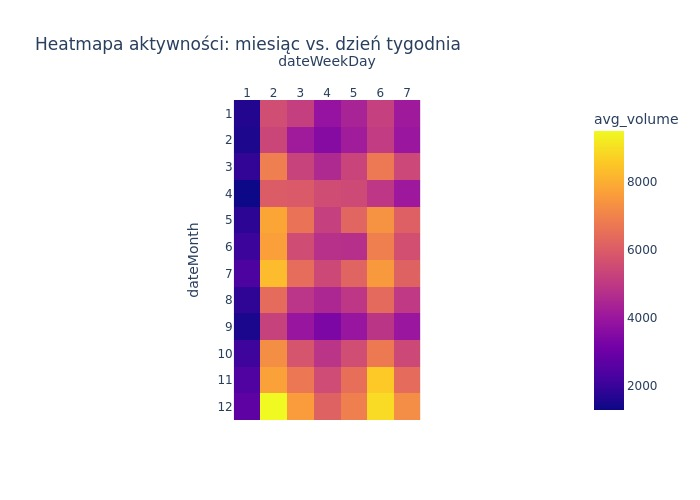

In [42]:
df_heatmap = (
    df_joined_final.group_by(["dateMonth", "dateWeekDay"])
    .agg(pl.mean("Volume").alias("avg_volume"))
    .sort(["dateMonth", "dateWeekDay"])
).to_pandas()

df_matrix = df_heatmap.pivot(
    index="dateMonth", columns="dateWeekDay", values="avg_volume"
)

fig = px.imshow(
    df_matrix,
    labels=dict(x="dateWeekDay", y="dateMonth", color="avg_volume"),
    x=[f"{d}" for d in df_matrix.columns],  
    y=[f"{m}" for m in df_matrix.index],  
    title="Heatmapa aktywności: miesiąc vs. dzień tygodnia",
)

fig.update_xaxes(side="top")  
# fig.show()
pio.show(fig)

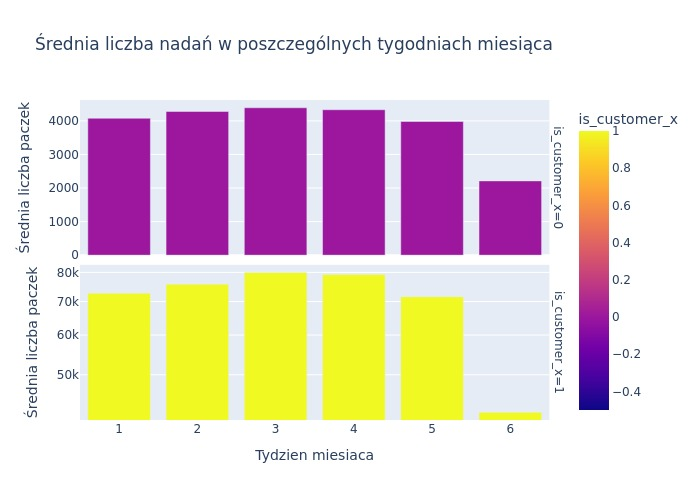

In [43]:
df_grouped_month = df_joined_final.group_by(["dateWeekOfMonth", "is_customer_x"]).agg(
    pl.mean("Volume").alias("avg_volume")
)
fig = px.bar(
    df_grouped_month,
    x="dateWeekOfMonth",
    y="avg_volume",
    color="is_customer_x",
    facet_row= "is_customer_x",
    title="Średnia liczba nadań w poszczególnych tygodniach miesiąca",
    labels={"dateWeekOfMonth": "Tydzien miesiaca", "avg_volume": "Średnia liczba paczek"},
)
fig.update_layout(yaxis_type="log")

# fig.show()
pio.show(fig)

In [44]:
mean_is_holiday = df_joined_final.group_by(["dateIsHolidayInd", "is_customer_x"]).agg(
    pl.mean("Volume").alias("avg_volume")
)
corr_is_holiday = df_joined_final.group_by("is_customer_x").agg(
    pl.corr("Volume", "dateIsHolidayInd").alias("corr")
)

print(corr_is_holiday, mean_is_holiday)

shape: (2, 2)
┌───────────────┬───────────┐
│ is_customer_x ┆ corr      │
│ ---           ┆ ---       │
│ i32           ┆ f64       │
╞═══════════════╪═══════════╡
│ 0             ┆ -0.197882 │
│ 1             ┆ -0.384872 │
└───────────────┴───────────┘ shape: (4, 3)
┌──────────────────┬───────────────┬──────────────┐
│ dateIsHolidayInd ┆ is_customer_x ┆ avg_volume   │
│ ---              ┆ ---           ┆ ---          │
│ i64              ┆ i32           ┆ f64          │
╞══════════════════╪═══════════════╪══════════════╡
│ 0                ┆ 0             ┆ 4372.868129  │
│ 1                ┆ 0             ┆ 223.573658   │
│ 0                ┆ 1             ┆ 78821.605398 │
│ 1                ┆ 1             ┆ 4080.843284  │
└──────────────────┴───────────────┴──────────────┘


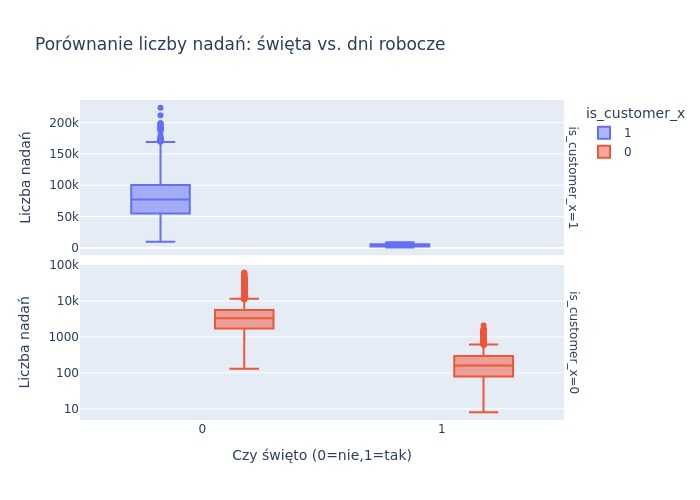

In [45]:
fig = px.box(
    df_joined_final,
    x="dateIsHolidayInd",
    y="Volume",
    color="is_customer_x",
    facet_row="is_customer_x",
    title="Porównanie liczby nadań: święta vs. dni robocze",
    labels={"dateIsHolidayInd": "Czy święto (0=nie,1=tak)", "Volume": "Liczba nadań"},
)
fig.update_layout(yaxis_type="log")
# fig.show()
pio.show(fig)

In [46]:
holidays_data_x = df_joined_final.filter((pl.col("dateIsHolidayInd") == 1) & (pl.col("is_customer_x") == 1)).select("Volume")
non_holidays_data_x = df_joined_final.filter((pl.col("dateIsHolidayInd") == 0) & (pl.col("is_customer_x") == 1)).select("Volume")

holidays_data = df_joined_final.filter((pl.col("dateIsHolidayInd") == 1) & (pl.col("is_customer_x") == 0)).select("Volume")
non_holidays_data = df_joined_final.filter((pl.col("dateIsHolidayInd") == 0) & (pl.col("is_customer_x") == 0)).select("Volume")

stat, pvalue = st.ttest_ind(holidays_data_x, non_holidays_data_x, equal_var=False)
print("Customer X:", "t-stat:", stat, "p-value:", pvalue)

stat, pvalue = st.ttest_ind(holidays_data, non_holidays_data, equal_var=False)
print("Other customers:", "t-stat:", stat, "p-value:", pvalue)

Customer X: t-stat: [-123.18429519] p-value: [0.]
Other customers: t-stat: [-502.71846674] p-value: [0.]


In [47]:
df_WeekendParcelServiceBreak = df_joined_final.group_by(["is_customer_x", "isWeekendParcelServiceBreakInd"]).agg(
    pl.mean("Volume").alias("avg_volume")
).sort("is_customer_x")

corr_is_weekend_break = df_joined_final.group_by("is_customer_x").agg(
    pl.corr("Volume", "isWeekendParcelServiceBreakInd").alias("corr")
)

print(df_WeekendParcelServiceBreak, corr_is_weekend_break)

shape: (6, 3)
┌───────────────┬────────────────────────────────┬──────────────┐
│ is_customer_x ┆ isWeekendParcelServiceBreakInd ┆ avg_volume   │
│ ---           ┆ ---                            ┆ ---          │
│ i32           ┆ f64                            ┆ f64          │
╞═══════════════╪════════════════════════════════╪══════════════╡
│ 0             ┆ 0.0                            ┆ 4560.618839  │
│ 0             ┆ null                           ┆ 2841.036147  │
│ 0             ┆ 1.0                            ┆ 2021.378824  │
│ 1             ┆ 0.0                            ┆ 79566.482627 │
│ 1             ┆ null                           ┆ 64724.79235  │
│ 1             ┆ 1.0                            ┆ 36999.977273 │
└───────────────┴────────────────────────────────┴──────────────┘ shape: (2, 2)
┌───────────────┬───────────┐
│ is_customer_x ┆ corr      │
│ ---           ┆ ---       │
│ i32           ┆ f64       │
╞═══════════════╪═══════════╡
│ 0             ┆ -0.072095 │


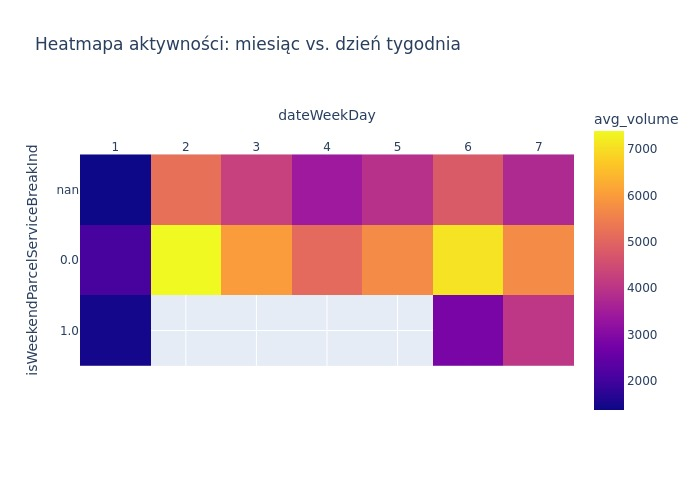

In [48]:
df_heatmap = (
    df_joined.group_by(["isWeekendParcelServiceBreakInd", "dateWeekDay"])
    .agg(pl.mean("Volume").alias("avg_volume"))
    .sort(["isWeekendParcelServiceBreakInd", "dateWeekDay"])
)
df_heatmap_pd = df_heatmap.to_pandas()
df_matrix = df_heatmap_pd.pivot(
    index="isWeekendParcelServiceBreakInd", columns="dateWeekDay", values="avg_volume"
)

fig = px.imshow(
    df_matrix,
    labels=dict(
        x="dateWeekDay", y="isWeekendParcelServiceBreakInd", color="avg_volume"
    ),
    x=[f"{d}" for d in df_matrix.columns],  
    y=[f"{m}" for m in df_matrix.index],  
    title="Heatmapa aktywności: miesiąc vs. dzień tygodnia",
)

fig.update_xaxes(side="top") 
# fig.show()
pio.show(fig)

In [49]:
df_isThuHolyday = df_joined_final.group_by(["is_customer_x", "isThuHolyday"]).agg(
    pl.mean("Volume").alias("avg_volume")
).sort("is_customer_x")

print(df_isThuHolyday)

shape: (4, 3)
┌───────────────┬──────────────┬──────────────┐
│ is_customer_x ┆ isThuHolyday ┆ avg_volume   │
│ ---           ┆ ---          ┆ ---          │
│ i32           ┆ i64          ┆ f64          │
╞═══════════════╪══════════════╪══════════════╡
│ 0             ┆ 0            ┆ 4240.413707  │
│ 0             ┆ 1            ┆ 3437.993155  │
│ 1             ┆ 0            ┆ 76446.413348 │
│ 1             ┆ 1            ┆ 61261.068182 │
└───────────────┴──────────────┴──────────────┘


In [50]:
df_isFriHolyday = df_joined_final.group_by(["is_customer_x", "isFriHolyday"]).agg(
    pl.mean("Volume").alias("avg_volume")
).sort("is_customer_x")

print(df_isFriHolyday)

shape: (4, 3)
┌───────────────┬──────────────┬──────────────┐
│ is_customer_x ┆ isFriHolyday ┆ avg_volume   │
│ ---           ┆ ---          ┆ ---          │
│ i32           ┆ i64          ┆ f64          │
╞═══════════════╪══════════════╪══════════════╡
│ 0             ┆ 0            ┆ 4245.381686  │
│ 0             ┆ 1            ┆ 3000.367351  │
│ 1             ┆ 0            ┆ 76472.908152 │
│ 1             ┆ 1            ┆ 56568.430556 │
└───────────────┴──────────────┴──────────────┘


In [51]:
df_isSatHolyday = df_joined_final.group_by(["is_customer_x", "isSatHolyday"]).agg(
    pl.mean("Volume").alias("avg_volume")
).sort("is_customer_x")

print(df_isSatHolyday)

shape: (4, 3)
┌───────────────┬──────────────┬──────────────┐
│ is_customer_x ┆ isSatHolyday ┆ avg_volume   │
│ ---           ┆ ---          ┆ ---          │
│ i32           ┆ i64          ┆ f64          │
╞═══════════════╪══════════════╪══════════════╡
│ 0             ┆ 0            ┆ 4237.53628   │
│ 0             ┆ 1            ┆ 3135.287855  │
│ 1             ┆ 1            ┆ 59710.625    │
│ 1             ┆ 0            ┆ 76335.488883 │
└───────────────┴──────────────┴──────────────┘


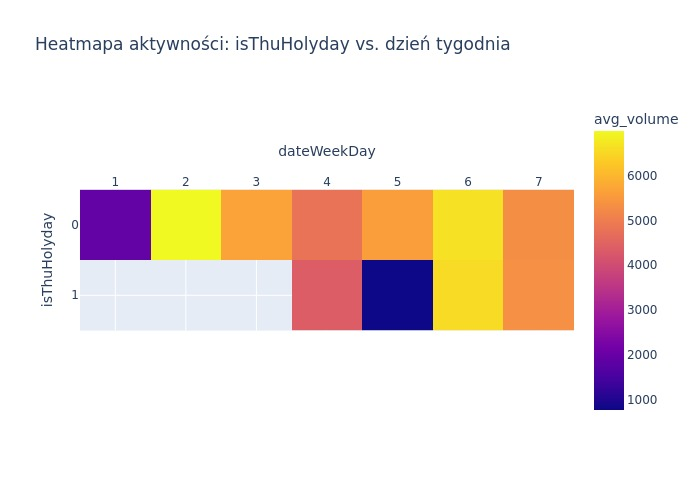

In [52]:
df_heatmap = (
    df_joined.group_by(["isThuHolyday", "dateWeekDay"])
    .agg(pl.mean("Volume").alias("avg_volume"))
    .sort(["isThuHolyday", "dateWeekDay"])
)
df_heatmap_pd = df_heatmap.to_pandas()
df_matrix = df_heatmap_pd.pivot(
    index="isThuHolyday", columns="dateWeekDay", values="avg_volume"
)

fig = px.imshow(
    df_matrix,
    labels=dict(x="dateWeekDay", y="isThuHolyday", color="avg_volume"),
    x=[f"{d}" for d in df_matrix.columns], 
    y=[f"{m}" for m in df_matrix.index],  
    title="Heatmapa aktywności: isThuHolyday vs. dzień tygodnia",
)

fig.update_xaxes(side="top")  
# fig.show()
pio.show(fig)

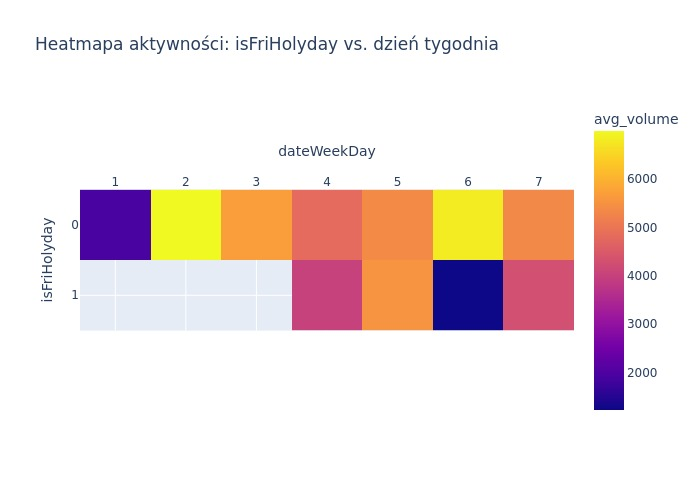

In [53]:
df_heatmap = (
    df_joined.group_by(["isFriHolyday", "dateWeekDay"])
    .agg(pl.mean("Volume").alias("avg_volume"))
    .sort(["isFriHolyday", "dateWeekDay"])
)
df_heatmap_pd = df_heatmap.to_pandas()
df_matrix = df_heatmap_pd.pivot(
    index="isFriHolyday", columns="dateWeekDay", values="avg_volume"
)
fig = px.imshow(
    df_matrix,
    labels=dict(x="dateWeekDay", y="isFriHolyday", color="avg_volume"),
    x=[f"{d}" for d in df_matrix.columns],  
    y=[f"{m}" for m in df_matrix.index], 
    title="Heatmapa aktywności: isFriHolyday vs. dzień tygodnia",
)

fig.update_xaxes(side="top")
# fig.show()
pio.show(fig)

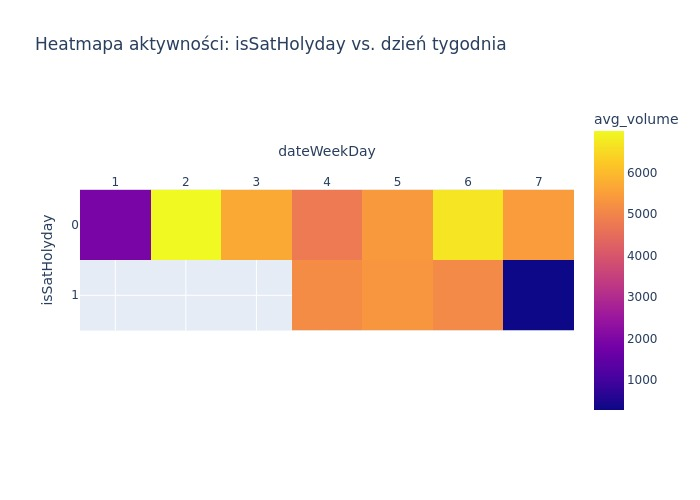

In [54]:
df_heatmap = (
    df_joined.group_by(["isSatHolyday", "dateWeekDay"])
    .agg(pl.mean("Volume").alias("avg_volume"))
    .sort(["isSatHolyday", "dateWeekDay"])
)
df_heatmap_pd = df_heatmap.to_pandas()
df_matrix = df_heatmap_pd.pivot(
    index="isSatHolyday", columns="dateWeekDay", values="avg_volume"
)
fig = px.imshow(
    df_matrix,
    labels=dict(x="dateWeekDay", y="isSatHolyday", color="avg_volume"),
    x=[f"{d}" for d in df_matrix.columns],  
    y=[f"{m}" for m in df_matrix.index],  
    title="Heatmapa aktywności: isSatHolyday vs. dzień tygodnia",
)

fig.update_xaxes(side="top")  
# fig.show()
pio.show(fig)

In [55]:
df_joined_final = df_joined_final.sort(["Customer", "Date"])
min_date = df_joined_final.select(pl.col("Date").min())

df_joined_final = df_joined_final.with_columns(
    (pl.col("Date") - pl.lit(min_date)).dt.total_days().alias("daysSinceStart")
)

df_corr = df_joined_final.group_by("Customer").agg(
    [pl.corr("daysSinceStart", "Volume").alias("corr_time_volume")]
)

print(df_corr, df_corr.select("corr_time_volume").min(), df_corr.select("corr_time_volume").max())

shape: (94, 2)
┌──────────────┬──────────────────┐
│ Customer     ┆ corr_time_volume │
│ ---          ┆ ---              │
│ str          ┆ f64              │
╞══════════════╪══════════════════╡
│ Customer_A1  ┆ 0.048236         │
│ Customer_A10 ┆ 0.166895         │
│ Customer_A11 ┆ 0.254267         │
│ Customer_A12 ┆ 0.661624         │
│ Customer_A13 ┆ 0.677558         │
│ …            ┆ …                │
│ Customer_A96 ┆ 0.184168         │
│ Customer_A97 ┆ 0.188431         │
│ Customer_A98 ┆ 0.146351         │
│ Customer_A99 ┆ 0.401167         │
│ Customer_X   ┆ 0.261259         │
└──────────────┴──────────────────┘ shape: (1, 1)
┌──────────────────┐
│ corr_time_volume │
│ ---              │
│ f64              │
╞══════════════════╡
│ -0.220326        │
└──────────────────┘ shape: (1, 1)
┌──────────────────┐
│ corr_time_volume │
│ ---              │
│ f64              │
╞══════════════════╡
│ 0.707003         │
└──────────────────┘


In [56]:
df_all = df_joined_final.with_columns([
    pl.col("Volume").shift(1).over("Customer").alias("lag_1"),
    pl.col("Volume").shift(7).over("Customer").alias("lag_7"),
    pl.col("Volume").shift(14).over("Customer").alias("lag_14"),
])


In [57]:

corr_lag1 = df_all.group_by("is_customer_x").agg(
    pl.corr("Volume", "lag_1").alias("corr_lag1")
)


corr_lag7 = df_all.group_by("is_customer_x").agg(
    pl.corr("Volume", "lag_7").alias("corr_lag7")
)


corr_lag14 = df_all.group_by("is_customer_x").agg(
    pl.corr("Volume", "lag_14").alias("corr_lag14")
)

print(corr_lag1, corr_lag7, corr_lag14)

shape: (2, 2)
┌───────────────┬───────────┐
│ is_customer_x ┆ corr_lag1 │
│ ---           ┆ ---       │
│ i32           ┆ f64       │
╞═══════════════╪═══════════╡
│ 0             ┆ 0.788457  │
│ 1             ┆ 0.512269  │
└───────────────┴───────────┘ shape: (2, 2)
┌───────────────┬───────────┐
│ is_customer_x ┆ corr_lag7 │
│ ---           ┆ ---       │
│ i32           ┆ f64       │
╞═══════════════╪═══════════╡
│ 0             ┆ 0.751812  │
│ 1             ┆ 0.346158  │
└───────────────┴───────────┘ shape: (2, 2)
┌───────────────┬────────────┐
│ is_customer_x ┆ corr_lag14 │
│ ---           ┆ ---        │
│ i32           ┆ f64        │
╞═══════════════╪════════════╡
│ 0             ┆ 0.850091   │
│ 1             ┆ 0.662117   │
└───────────────┴────────────┘


In [ ]:
df_customer_x = df_all.filter(pl.col("is_customer_x") == 1)
df_customer_x.write_parquet('df_customer_x.parquet')
df_customers_no_x = df_all.filter(pl.col("is_customer_x") == 0)
df_customers_no_x.write_parquet('df_customers_no_x.parquet')


Ze względu na wyraźnie różne charakterystyki zdecydowałam się na zbudowanie dwóch modeli XGBoost, osobno dla klienta X oraz reszty klientów